In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random
from PIL import Image 
import matplotlib.image as mpimg 
import cv2

In [3]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

Shuffling and writing examples to tmp/rock_paper_scissors/3.0.0.incompleteWHITMY/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to tmp/rock_paper_scissors/3.0.0.incompleteWHITMY/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to tmp/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [4]:
#(300,300,3)
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

In [5]:
print(NUM_TRAIN_EXAMPLES)
print(NUM_TEST_EXAMPLES)
print(NUM_CLASSES)

2520
372
3


In [6]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = INPUT_IMG_SIZE_ORIGINAL // 2
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

In [7]:
get_label_name = dataset_info.features['label'].int2str
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = get_label_name(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

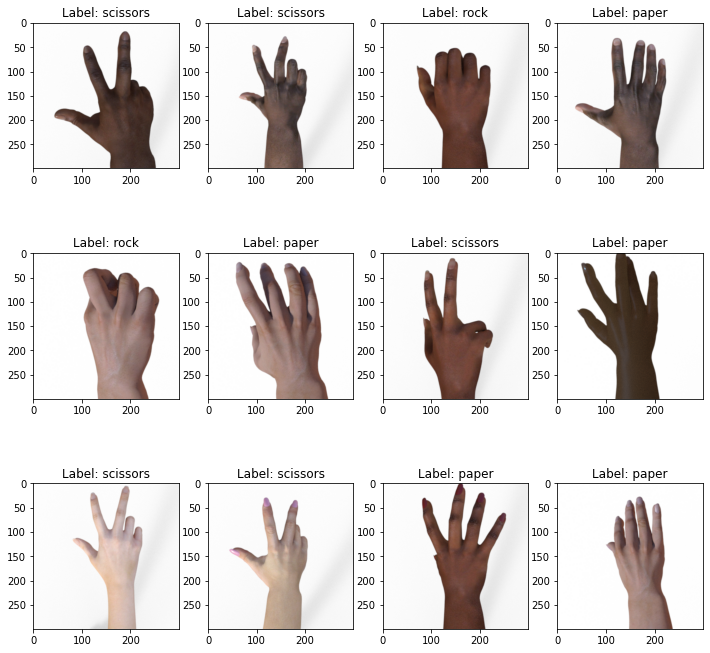

In [8]:
preview_dataset(dataset_train_raw)

In [9]:
#Exploring numerical representation
(first_image, first_lable) = list(dataset_train_raw.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (300, 300, 3) 

[[[254 254 254]
  [253 253 253]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [250 250 250]]

 [[254 254 254]
  [254 254 254]
  [253 253 253]
  ...
  [250 250 250]
  [251 251 251]
  [249 249 249]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [252 252 252]]

 ...

 [[252 252 252]
  [251 251 251]
  [252 252 252]
  ...
  [247 247 247]
  [249 249 249]
  [248 248 248]]

 [[253 253 253]
  [253 253 253]
  [251 251 251]
  ...
  [248 248 248]
  [248 248 248]
  [248 248 248]]

 [[252 252 252]
  [253 253 253]
  [252 252 252]
  ...
  [248 248 248]
  [247 247 247]
  [250 250 250]]]


In [10]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [11]:
#resize
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

In [12]:
#values between 0 & 1  
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())

Label: 2 

Image shape: (150, 150, 3) 

[[[0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9843137  0.9843137  0.9843137 ]
  [0.98039216 0.98039216 0.98039216]]

 [[0.99607843 0.99607843 0.99607843]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.98333335 0.98333335 0.98333335]
  [0.9813726  0.9813726  0.9813726 ]
  [0.98333335 0.98333335 0.98333335]]

 [[0.99607843 0.99607843 0.99607843]
  [0.9941176  0.9941176  0.9941176 ]
  [0.9941176  0.9941176  0.9941176 ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9852941  0.9852941  0.9852941 ]
  [0.9813726  0.9813726  0.9813726 ]]

 ...

 [[0.9862745  0.9862745  0.9862745 ]
  [0.98725486 0.98725486 0.98725486]
  [0.9882353  0.9882353  0.9882353 ]
  ...
  [0.9705882  0.9705882  0.9705882 ]
  [0.97352946 0.97352946 0.97352946]
  [0.9754902  0.9754902  0.9754902 ]]

 [[0.9882353  0.9882353  0.9882353

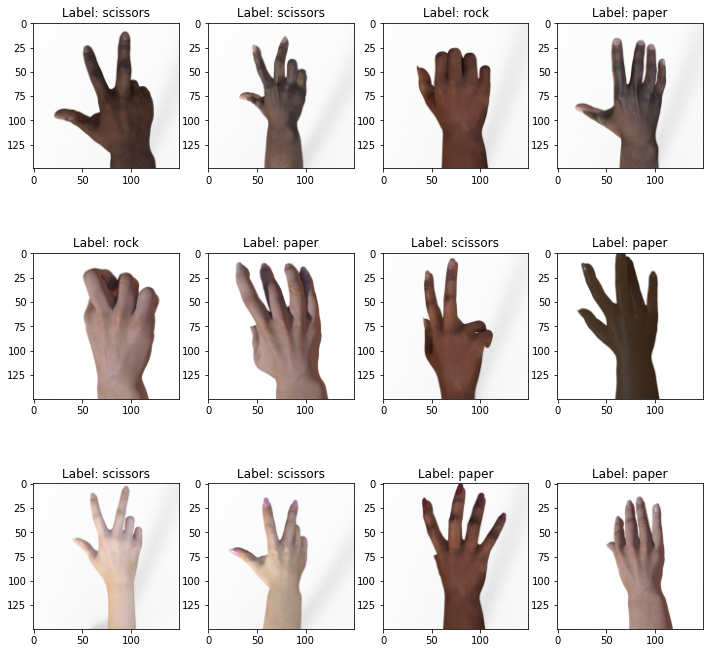

In [13]:
preview_dataset(dataset_train)

In [14]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [15]:
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [20]:
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

In [21]:
def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    return image, label

In [22]:
dataset_train_augmented = dataset_train.map(augment_data)

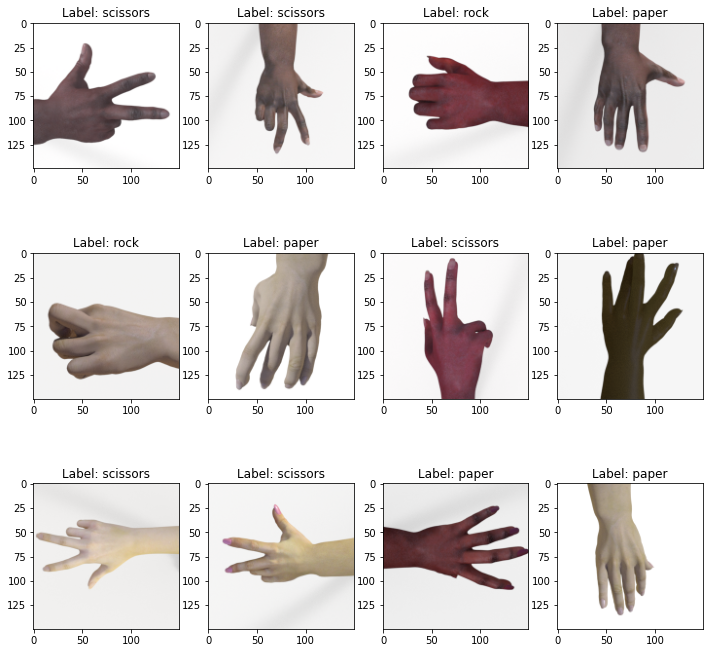

In [23]:
# Explore augmented training dataset.
import cv2
preview_dataset(dataset_train_augmented)

In [24]:
#making batches of size=32
BATCH_SIZE = 32

dataset_train_augmented_shuffled = dataset_train_augmented.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_augmented_shuffled = dataset_train_augmented.batch(
    batch_size=BATCH_SIZE
)


dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [ ]:
model = tf.keras.models.Sequential()

# First convolution.
model.add(tf.keras.layers.Convolution2D(
    input_shape=INPUT_IMG_SHAPE,
    filters=64,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Second convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=64,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Third convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=128,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Fourth convolution.
model.add(tf.keras.layers.Convolution2D(
    filters=128,
    kernel_size=3,
    activation=tf.keras.activations.relu
))
model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

# Flatten the results to feed into dense layers.
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5))

# 512 neuron dense layer.
model.add(tf.keras.layers.Dense(
    units=512,
    activation=tf.keras.activations.relu
))

# Output layer.
model.add(tf.keras.layers.Dense(
    units=NUM_CLASSES,
    activation=tf.keras.activations.softmax
))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=rmsprop_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [ ]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE

In [ ]:
training_history = model.fit(
    x=dataset_train_augmented_shuffled.repeat(),
    validation_data=dataset_test_shuffled.repeat(),
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        # model_checkpoint_callback,
        # early_stopping_callback,
        tensorboard_callback
    ],
    verbose=1
)

Epoch 1/15
78/78 [==============================] - 169s 2s/step - loss: 1.4344 - accuracy: 0.3742 - val_loss: 0.8798 - val_accuracy: 0.5597
Epoch 2/15
78/78 [==============================] - 167s 2s/step - loss: 0.7051 - accuracy: 0.7288 - val_loss: 0.6347 - val_accuracy: 0.7415
Epoch 3/15
78/78 [==============================] - 168s 2s/step - loss: 0.2963 - accuracy: 0.8986 - val_loss: 0.9219 - val_accuracy: 0.7386
Epoch 4/15
78/78 [==============================] - 168s 2s/step - loss: 0.1435 - accuracy: 0.9568 - val_loss: 0.5403 - val_accuracy: 0.8040
Epoch 5/15
78/78 [==============================] - 169s 2s/step - loss: 0.1101 - accuracy: 0.9686 - val_loss: 0.7331 - val_accuracy: 0.7614
Epoch 6/15
78/78 [==============================] - 174s 2s/step - loss: 0.0810 - accuracy: 0.9750 - val_loss: 0.8097 - val_accuracy: 0.7869
Epoch 7/15
78/78 [==============================] - 173s 2s/step - loss: 0.0912 - accuracy: 0.9699 - val_loss: 0.4688 - val_accuracy: 0.8438
Epoch 8/15
78

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

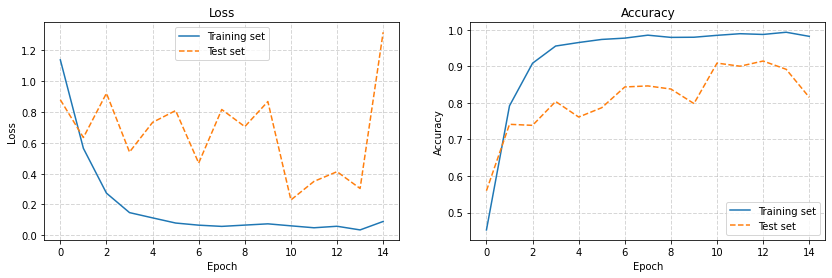

In [ ]:
render_training_history(training_history)

In [ ]:
# %%capture
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

12/12 [==============================] - 7s 569ms/step - loss: 1.2787 - accuracy: 0.8226


In [ ]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

Training loss:  0.0032568296883255243
Training accuracy:  0.9988095164299011


Test loss:  1.2787419557571411
Test accuracy:  0.8225806355476379


In [ ]:
model_name = 'rock_paper_scissors_cnn.h5'
model.save(model_name, save_format='h5')

In [ ]:
y=model.predict(result)

In [ ]:
import cv2
q=Image.open("WIN_20190929_05_12_10_Pro.jpg")
hsv = cv2.cvtColor(q,cv2.COLOR_BGR2HSV)
range1 = (20,80,80)
range2 = (90,255,255)
mask = cv2.inRange(hsv,range1,range2)
mask = 255 - mask
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.GaussianBlur(mask, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)
mask = skimage.exposure.rescale_intensity(mask, in_range=(127.5,255), out_range=(0,255))
result = img.copy()
result[mask==0] = (255,255,255)
result=result/255;
result=cv2.resize(result,(150,150))

In [ ]:
y=model.predict(result)

array([[2.9006928e-14, 2.0084737e-10, 1.0000000e+00],
       [8.2763631e-07, 1.6876078e-03, 9.9831152e-01],
       [1.0000000e+00, 1.3837574e-11, 2.7718497e-25],
       ...,
       [2.5802728e-11, 9.9999988e-01, 1.5817331e-07],
       [1.7417596e-04, 9.9965346e-01, 1.7236787e-04],
       [1.1066889e-09, 9.9999392e-01, 6.1134197e-06]], dtype=float32)

In [ ]:
ans=np.argmax(y)

2